# Задача 1
-Напишите токенайзенр на основе BPE, используя претокенизацию и специальные токены. Можете использовать паттерны претокенизации открытых моделей, указав источник.

Обучите свой токенизатор на своем корпусе, токенизируйте тексты, не совпадающие с использованным для обучения.

* Определите коэффициент сжатия (число токенов к количеству байт/символов), среднее количество токенов на слово, среднее количество токенов на слово для топ 10% частотных слов. 
* Ответьте на вопрос, отличается ли эффективность для разных доменов?
* Постройте кривую: размер словаря vs compression ratio
* Определите, какая часть токенов не использовалась ни разу при токенизации корпуса стихотворений Пушкина

In [ ]:
import math
import random
from collections import Counter, defaultdict
from pathlib import Path
from typing import Dict, List, Optional, Set, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as _re
import seaborn as sns
import torch
import torch.nn as nn
from datasets import Dataset
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)

set_seed(42)
rng = np.random.default_rng(42)

Для обучения будем использовать тот же датасет с анекдотами, разбив его на train/test в соотношении 80/20

In [ ]:
# Download latest version
path = kagglehub.dataset_download("michaelstepanovsky/anecdoted")


c:\Users\user\PycharmProjects\trader\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# для претокенизации использую аналогичное выражение GPT-2
# источник: https://github.com/openai/gpt-2/blob/master/src/encoder.py


_GPT2_PRETOKENIZE_PATTERN = _re.compile(
        r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
    )

In [8]:
def count_pairs(data: List[List[int]]) -> Dict[Tuple[int, int], int]:
    """
    Считает частоты соседних пар (bigram) в данных, представленных списками int.

    Параметры:
    ----------
    data: List[List[int]]
        Список последовательностей токенов (int).

    Возвращает:
    -----------
    Dict[Tuple[int, int], int]
        Частоты пар.
    """
    pairs = defaultdict(int)
    for sentence in data:
        for i in range(len(sentence) - 1):
            pairs[(sentence[i], sentence[i + 1])] += 1
    return dict(pairs)

In [9]:
def merge(numbers: List[int], pair: Tuple[int, int], idx: int) -> List[int]:
    """
    Слева направо заменяет все вхождения пары `pair` на токен `idx`
    """
    new_numbers = []
    i = 0
    while i < len(numbers) - 1:
        if (numbers[i], numbers[i + 1]) == pair:
            new_numbers.append(idx)
            i += 2
        else:
            new_numbers.append(numbers[i])
            i += 1

    if i == len(numbers) - 1:
        new_numbers.append(numbers[-1])

    return new_numbers

In [10]:
class ByteTokenizer:
    """
    Базовый байтовый токенизатор:
    - encode: UTF-8 -> список байтов (0..255)
    - decode: список id -> bytes -> UTF-8

    Поддерживает спецтокены:
    - <pad>, <bos>, <eos>, <unk>
    """
    def __init__(self):
        self.pad_token = b"<pad>"
        self.bos_token = b"<bos>"
        self.eos_token = b"<eos>"
        self.unk_token = b"<unk>"

        self.pad_token_id: Optional[int] = None
        self.bos_token_id: Optional[int] = None
        self.eos_token_id: Optional[int] = None
        self.unk_token_id: Optional[int] = None

        self.special_tokens = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]
        self.vocab: Dict[int, bytes] = {}
        self.init_vocab()

    def init_vocab(self) -> None:
        """Инициализирует vocab: 0..255 как байты + спецтокены сверху."""
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for token in self.special_tokens:
            idx = len(self.vocab)
            self.vocab[idx] = token

        token_to_id = {y: x for x, y in self.vocab.items()}
        self.pad_token_id = token_to_id[self.pad_token]
        self.bos_token_id = token_to_id[self.bos_token]
        self.eos_token_id = token_to_id[self.eos_token]
        self.unk_token_id = token_to_id[self.unk_token]

    def train(self, texts: List[str], max_vocab: int) -> None:
        """Базовый класс: просто сбрасывает vocab."""
        self.init_vocab()

    def encode(self, text: str) -> List[int]:
        """UTF-8 bytes -> ids."""
        return list(text.encode("utf-8"))

    def decode(self, ids: List[int], skip_special_tokens: bool = True) -> str:
        """
        ids -> bytes -> UTF-8 string.

        Если skip_special_tokens=True, то <pad>/<bos>/<eos>/<unk> выкидываются.
        """
        if self.pad_token_id is None:
            raise RuntimeError("Tokenizer vocab not initialized")

        special_ids = set()
        if skip_special_tokens:
            special_ids = {self.pad_token_id, self.bos_token_id, self.eos_token_id, self.unk_token_id}

        out_bytes = []
        for idx in ids:
            if skip_special_tokens and idx in special_ids:
                continue
            out_bytes.append(self.vocab.get(idx, self.unk_token))
        return b"".join(out_bytes).decode("utf-8", errors="replace")

    def get_vocab_size(self) -> int:
        return len(self.vocab)


class BpeTokenizer(ByteTokenizer):
    """
    BPE токенизатор поверх байтов UTF-8 + претокенизация + спецтокены.
    """
    def __init__(self, use_pretokenization: bool = True):
        self.use_pretokenization = use_pretokenization

        # pair -> new_idx
        self.merges: Dict[Tuple[int, int], int] = {}
        self.merge_ranks: Dict[Tuple[int, int], int] = {}
        self.merge_rules: List[Tuple[int, int]] = []

        super().__init__()

    def init_vocab(self) -> None:
        super().init_vocab()
        self.merges = {}
        self.merge_ranks = {}
        self.merge_rules = []

    def pretokenize(self, text: str) -> List[str]:
        """"""
        return _GPT2_PRETOKENIZE_PATTERN.findall(text)

    def _best_merge_pair(self, ids: List[int]) -> Optional[Tuple[int, int]]:
        """
        Находит пару (i,i+1) с минимальным rank среди тех, что есть в merge_ranks.
        """
        best_pair = None
        best_rank = None
        for i in range(len(ids) - 1):
            p = (ids[i], ids[i + 1])
            r = self.merge_ranks.get(p)
            if r is None:
                continue
            if best_rank is None or r < best_rank:
                best_rank = r
                best_pair = p
        return best_pair

    def _apply_bpe(self, ids: List[int]) -> List[int]:
        """
        Применяет BPE merges корректно: всегда выбирает пару с наивысшим приоритетом (минимальный rank),
        и мерджит до тех пор, пока нечего мерджить.
        """
        if len(ids) < 2 or not self.merge_ranks:
            return ids

        while len(ids) > 1:
            pair = self._best_merge_pair(ids)
            if pair is None:
                break
            ids = merge(ids, pair, self.merges[pair])
        return ids

    def train(
        self,
        texts: List[str],
        max_vocab: int,
        min_pair_freq: int = 2,
        show_progress: bool = True,
    ) -> None:
        """
        Обучает merges по BPE:
        - Берем наиболее частую пару токенов
        - Заводим новый токен
        - Применяем merge ко всем тренировочным последовательностям
        - Повторяем, пока не исчерпаем max_vocab или частоты

        Параметры:
        ----------
        texts: List[str]
            Корпус.
        max_vocab: int
            Максимальный размер словаря.
        min_pair_freq: int
            Останавливаемся, если лучшая пара встречается реже.
        """
        self.init_vocab()

        if max_vocab <= len(self.vocab):
            return

        list_of_ids: List[List[int]] = []

        if self.use_pretokenization:
            for text in texts:
                for piece in self.pretokenize(text):
                    ids = list(piece.encode("utf-8"))
                    if ids:
                        list_of_ids.append(ids)
        else:
            for text in texts:
                ids = list(text.encode("utf-8"))
                if ids:
                    list_of_ids.append(ids)

        if not list_of_ids:
            return

        steps = max_vocab - len(self.vocab)
        pbar = range(steps)
        if show_progress:
            pbar = tqdm(pbar, desc="Learn BPE merges", total=steps)

        for _ in pbar:
            cnt = count_pairs(list_of_ids)
            if not cnt:
                break

            pair = max(cnt, key=cnt.get)
            freq = cnt[pair]

            if show_progress:
                try:
                    pbar.set_description(f"pair={pair}, freq={freq}")
                except Exception:
                    pass

            if freq < min_pair_freq:
                break

            new_idx = len(self.vocab)
            self.merges[pair] = new_idx
            self.merge_ranks[pair] = len(self.merge_rules)
            self.merge_rules.append(pair)

            self.vocab[new_idx] = self.vocab[pair[0]] + self.vocab[pair[1]]
            for i, ids in enumerate(list_of_ids):
                list_of_ids[i] = merge(ids, pair, new_idx)

    def encode(self, text: str, add_special_tokens: bool = True) -> List[int]:
        """
        Кодирует текст:
        - pretokens -> bytes ids -> apply BPE
        - добавляет <bos>/<eos>, если add_special_tokens=True
        """
        if self.bos_token_id is None or self.eos_token_id is None:
            raise RuntimeError("Tokenizer vocab not initialized")

        out: List[int] = []
        if add_special_tokens:
            out.append(self.bos_token_id)

        if self.use_pretokenization:
            for piece in self.pretokenize(text):
                ids = list(piece.encode("utf-8"))
                ids = self._apply_bpe(ids)
                out.extend(ids)
        else:
            ids = list(text.encode("utf-8"))
            ids = self._apply_bpe(ids)
            out.extend(ids)

        if add_special_tokens:
            out.append(self.eos_token_id)

        return out

    def encode_batch(self, texts: List[str], add_special_tokens: bool = True) -> List[List[int]]:
        return [self.encode(t, add_special_tokens=add_special_tokens) for t in texts]

    def tokens(self, text: str, add_special_tokens: bool = True) -> List[bytes]:
        """
        дебаг: возвращает байтовые токены после BPE.
        """
        ids = self.encode(text, add_special_tokens=add_special_tokens)
        return [self.vocab.get(i, self.unk_token) for i in ids]

In [12]:
root = Path(path)
csv_files = sorted(root.rglob("*.csv"), key=lambda p: p.stat().st_size, reverse=True)

print("files: ", csv_files)

dataset = pd.read_csv(csv_files[0])

display(dataset.head(5))

print("Всего анекдотов: ", dataset.shape[0])

files:  [WindowsPath('C:/Users/user/.cache/kagglehub/datasets/michaelstepanovsky/anecdoted/versions/1/anecdotes_dataset.csv')]


,joke,word_count,char_count
0,Нижегородский купчина рассказывает своим друзь...,71,358
1,"- Папа, а марсиане есть?- Нет, сынок, кончилис...",21,78
2,- Где работает ваш муж?- Уже третий месяц на л...,28,126
3,"- Дорогой, я похожа на идеальную женщину ?- Не...",29,111
4,"- О, милая! Панировка этих котлет такая хрустя...",30,144


Всего анекдотов:  44108


In [16]:
anecdotes = dataset['joke'].values
idx = rng.permutation(len(anecdotes))

split = int(0.8 * len(anecdotes))
train_idx = idx[:split]
test_idx = idx[split:]

anecdotes_train = anecdotes[train_idx]
anecdotes_test = anecdotes[test_idx]

print("total:", len(anecdotes), "train:", len(anecdotes_train), "test:", len(anecdotes_test))

total: 44108 train: 35286 test: 8822


In [26]:
tokenizer = BpeTokenizer(use_pretokenization=True)
tokenizer.train(anecdotes_train, max_vocab=400, min_pair_freq=2, show_progress=True)


pair=(291, 306), freq=9157: 100%|██████████| 140/140 [03:34<00:00,  1.53s/it] 


In [18]:
print("Vocab size:", tokenizer.get_vocab_size())
print("Num merges:", len(tokenizer.merge_rules))

Vocab size: 400
Num merges: 140


In [19]:
# проверка
for t in anecdotes_test:
    ids = tokenizer.encode(t, add_special_tokens=True)
    decoded = tokenizer.decode(ids, skip_special_tokens=True)
    print("\nTEXT:   ", t)
    print("IDS:    ", ids)
    print("DECODE: ", decoded)
    toks = tokenizer.tokens(t, add_special_tokens=True)
    print("TOKENS: ", toks)
    break


TEXT:    Трое мужиков спорят, у кого жена в постели лучше. Один говорит:- Моя жена как вулкан!- Да ты что, неужели такая горячая?! Второй говорит:- А моя как ветер! Налетает, одежду срывает, и понеслось... Третий:- А моя как омут...- Что, такая тихая?- Да, с виду тихая, но зато как засосет!..
IDS:     [257, 208, 162, 267, 261, 263, 292, 357, 331, 294, 280, 319, 307, 386, 44, 339, 289, 330, 261, 358, 300, 262, 279, 388, 302, 311, 265, 361, 270, 278, 286, 263, 46, 260, 158, 285, 317, 322, 396, 290, 58, 45, 390, 261, 274, 358, 300, 262, 289, 309, 279, 270, 283, 281, 324, 33, 45, 372, 262, 296, 276, 365, 44, 342, 357, 311, 265, 296, 309, 262, 274, 322, 307, 274, 278, 262, 274, 63, 33, 351, 288, 267, 327, 322, 396, 290, 58, 45, 364, 292, 261, 274, 289, 309, 279, 284, 304, 33, 349, 301, 284, 318, 44, 298, 285, 272, 182, 285, 270, 280, 267, 276, 287, 318, 44, 293, 277, 344, 397, 283, 336, 275, 337, 46, 398, 267, 284, 273, 185, 58, 45, 364, 292, 261, 274, 289, 309, 298, 310, 385, 337, 46, 45,

### 1.1.1. Определите коэффициент сжатия (число токенов к количеству байт/символов), среднее количество токенов на слово, среднее количество токенов на слово для топ 10% частотных слов. 

In [20]:
_WORD_RE = _re.compile(r"\p{L}+(?:[-']\p{L}+)*|\p{N}+", flags=_re.UNICODE)

def words_from_text(text: str) -> list[str]:
    return _WORD_RE.findall(text)

In [21]:
rows = []
for t in tqdm(anecdotes_test, desc="Compute text-level metrics"):
    ids = tokenizer.encode(t, add_special_tokens=False)
    n_tokens = len(ids)
    n_bytes = len(t.encode("utf-8"))
    n_chars = len(t)
    n_words = len(words_from_text(t))

    rows.append((n_tokens, n_bytes, n_chars, n_words))

df_text = pd.DataFrame(rows, columns=["tokens", "bytes", "chars", "words"])
df_text["tokens_per_byte"] = df_text["tokens"] / df_text["bytes"].replace(0, np.nan)
df_text["tokens_per_char"] = df_text["tokens"] / df_text["chars"].replace(0, np.nan)
df_text["tokens_per_word_text"] = df_text["tokens"] / df_text["words"].replace(0, np.nan)

# "коэффициент сжатия" — по формулировке: tokens / bytes (и отдельно tokens / chars)
total_tokens = int(df_text["tokens"].sum())
total_bytes = int(df_text["bytes"].sum())
total_chars = int(df_text["chars"].sum())

compression_tokens_per_byte = total_tokens / total_bytes if total_bytes else np.nan
compression_tokens_per_char = total_tokens / total_chars if total_chars else np.nan

Compute text-level metrics: 100%|██████████| 8822/8822 [00:03<00:00, 2290.25it/s]


In [24]:
print("\n=== Сжатие (tokens / size) ===")
print("tokens/byte :", compression_tokens_per_byte)
print("tokens/char :", compression_tokens_per_char)

print("\n=== Text-level averages ===")
print(df_text[["tokens_per_byte", "tokens_per_char", "tokens_per_word_text"]].mean(numeric_only=True))


=== Сжатие (tokens / size) ===
tokens/byte : 0.37944110340122816
tokens/char : 0.6754180449142242

=== Text-level averages ===
tokens_per_byte         0.382732
tokens_per_char         0.677817
tokens_per_word_text    4.365085
dtype: float64


1) В среднем, 0.379 токена на байт, или обратно 1 / 0.379 ~ 2.64 байта на токен. 

    Т.к. отношение токенов к байтам меньше единицы, то BPE действительно склеивает частые последовательности в токены

2) Токенов на символ 0.675 или 1.48 символа на токен. Логично при небольшом объеме vocab_size

3) 4.4 токена в среднем на одно слово. Реалистично для русского языка

Получился неплохой результат. Его явно можно улучшить при увеличении vocab_size (будет показано ниже)

In [30]:
def _to_int_token_len(x) -> int:
    """
    Приводит значение к длине токенизации (int).
    Если x = список/np.array токенов -> берём len(x).
    Если x = число -> int(x).
    """
    if isinstance(x, (list, tuple, np.ndarray)):
        return int(len(x))
    # иногда прилетает numpy scalar
    if isinstance(x, (np.integer, np.floating)):
        return int(x)
    # если строка/объект — пробуем как число, иначе fallback
    try:
        return int(x)
    except Exception:
        return int(len(x))

In [33]:
word_counter = Counter()
for t in tqdm(anecdotes_test, desc="Count words"):
    word_counter.update(words_from_text(t))

# 4.2) токен-длина слова 
word_token_len: Dict[str, int] = {}
for w in tqdm(word_counter.keys(), desc="Tokenize unique words"):
    word_token_len[w] = tokenizer.encode(w, add_special_tokens=False)

df_words = pd.DataFrame({
    "word": list(word_counter.keys()),
    "freq": [word_counter[w] for w in word_counter.keys()],
    "tokens_per_word": [word_token_len[w] for w in word_counter.keys()],
})


Tokenize unique words: 100%|██████████| 50456/50456 [00:01<00:00, 49345.68it/s]


In [34]:
df_words["freq"] = pd.to_numeric(df_words["freq"], errors="coerce").fillna(0).astype(int)
df_words["tokens_per_word"] = df_words["tokens_per_word"].apply(_to_int_token_len).astype(int)

# Взвешенное среднее: "типичное слово-вхождение"
avg_tokens_per_word = float(
    np.average(df_words["tokens_per_word"].to_numpy(), weights=df_words["freq"].to_numpy())
)

# top 10% частотных слов (по уникальным словам)
top_n = int(np.ceil(0.10 * len(df_words)))
df_words_sorted = df_words.sort_values("freq", ascending=False).reset_index(drop=True)
df_top = df_words_sorted.head(top_n).copy()

avg_tokens_per_word_top10 = float(
    np.average(df_top["tokens_per_word"].to_numpy(), weights=df_top["freq"].to_numpy())
)

print("avg tokens/word (all):    ", avg_tokens_per_word)
print("avg tokens/word (top10%): ", avg_tokens_per_word_top10)

avg tokens/word (all):     4.023198411640284
avg tokens/word (top10%):  3.30591607924758


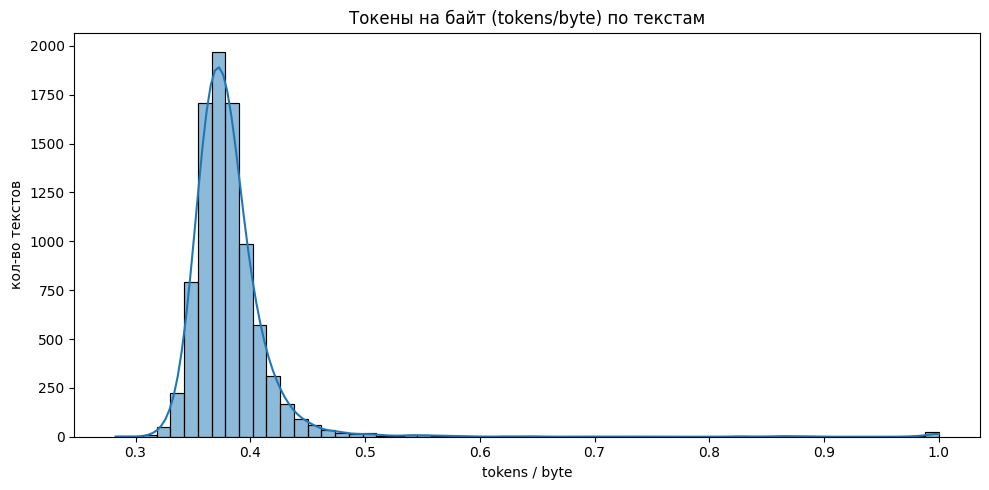

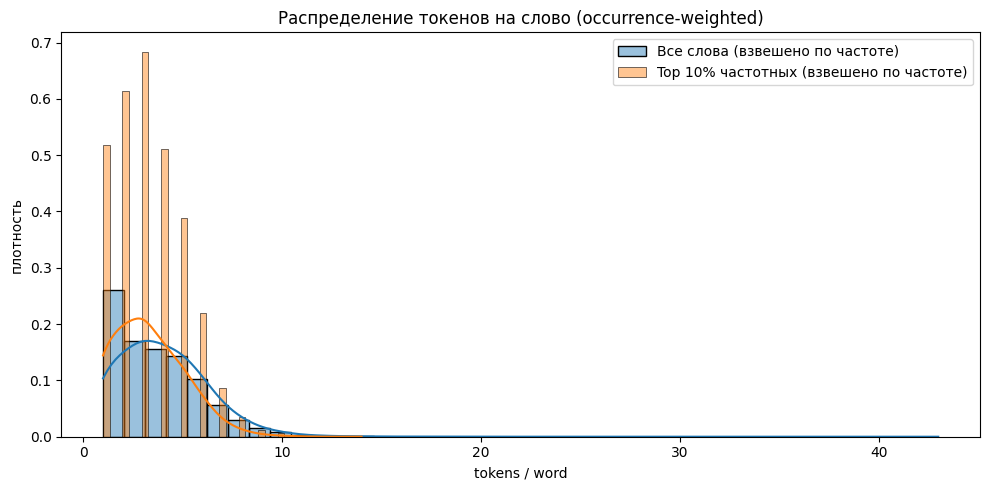

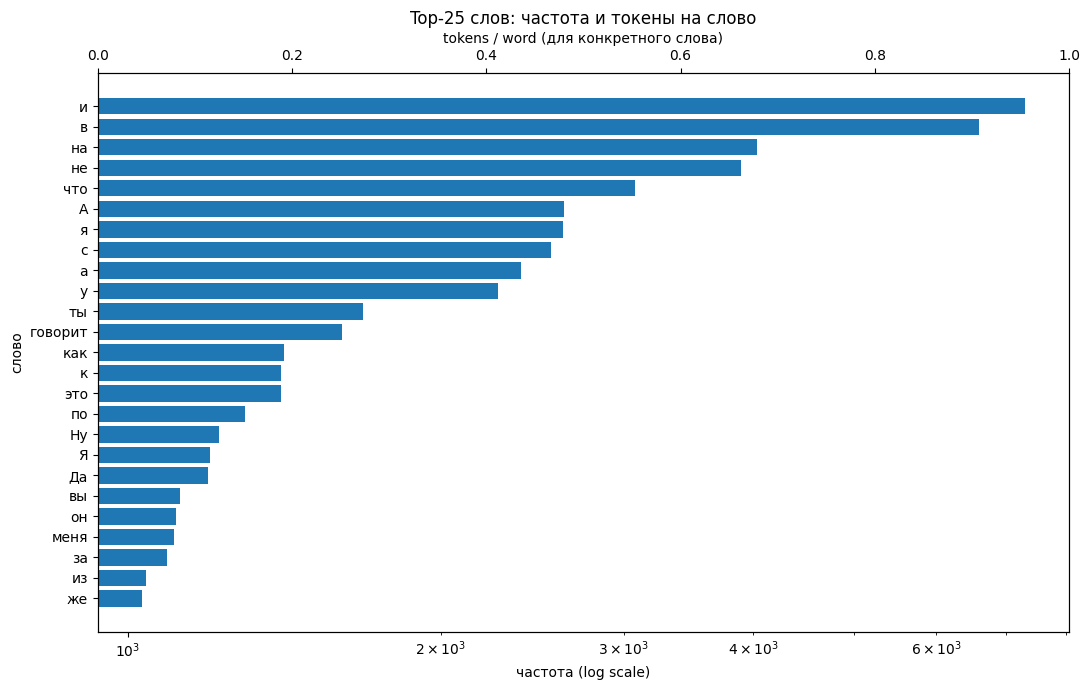

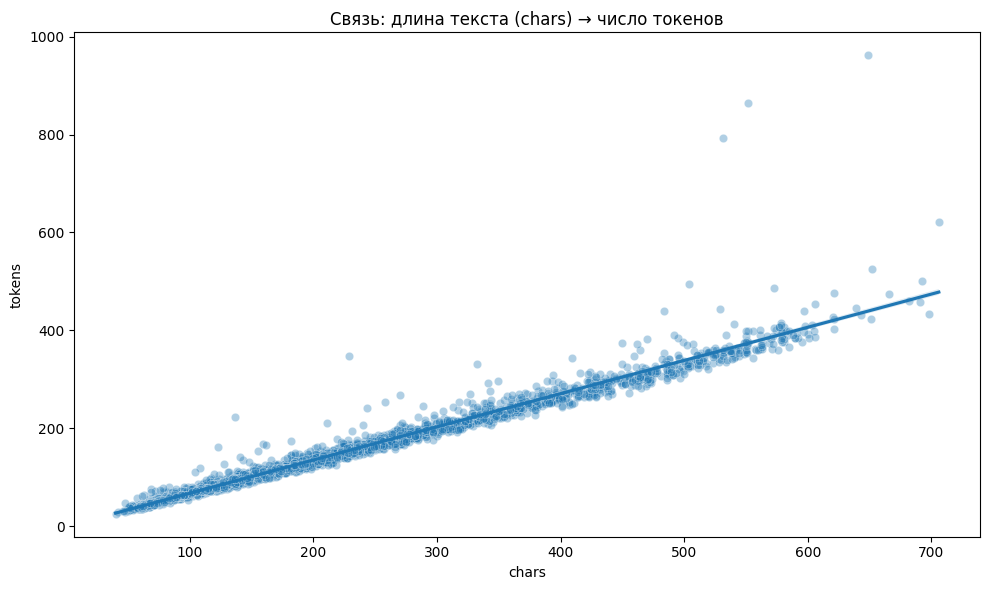

In [38]:
# 5.1) Распределение tokens/byte по текстам
plt.figure(figsize=(10, 5))
sns.histplot(df_text["tokens_per_byte"].dropna(), bins=60, kde=True)
plt.title("Токены на байт (tokens/byte) по текстам")
plt.xlabel("tokens / byte")
plt.ylabel("кол-во текстов")
plt.tight_layout()
plt.show()

# 5.2) Распределение tokens/word (по вхождениям) для всех слов vs top10%
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df_words,
    x="tokens_per_word",
    weights="freq",
    bins=40,
    kde=True,
    stat="density",
    alpha=0.45,
    label="Все слова (взвешено по частоте)",
)
sns.histplot(
    data=df_top,
    x="tokens_per_word",
    weights="freq",
    bins=40,
    kde=True,
    stat="density",
    alpha=0.45,
    label="Top 10% частотных (взвешено по частоте)",
)
plt.title("Распределение токенов на слово (occurrence-weighted)")
plt.xlabel("tokens / word")
plt.ylabel("плотность")
plt.legend()
plt.tight_layout()
plt.show()

# 5.3) Топ-25 слов: частота vs длина в токенах
top_k = 25
df_topk = df_words_sorted.head(top_k).copy()
df_topk = df_topk.sort_values("freq", ascending=True) 

fig, ax1 = plt.subplots(figsize=(11, 7))
ax1.barh(df_topk["word"], df_topk["freq"])
ax1.set_xscale("log")
ax1.set_xlabel("частота (log scale)")
ax1.set_ylabel("слово")
ax1.set_title("Top-25 слов: частота и токены на слово")

ax2 = ax1.twiny()
ax2.set_xlabel("tokens / word (для конкретного слова)")

plt.tight_layout()
plt.show()

# 5.4) Связь: длина текста (chars) -> tokens (scatter + тренд)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_text.sample(min(len(df_text), 4000), random_state=42), x="chars", y="tokens", alpha=0.35)
sns.regplot(data=df_text.sample(min(len(df_text), 4000), random_state=42), x="chars", y="tokens", scatter=False)
plt.title("Связь: длина текста (chars) → число токенов")
plt.xlabel("chars")
plt.ylabel("tokens")
plt.tight_layout()
plt.show()

Проанализируем полученные результаты:

1. Токены/байт по текстам

    Основная масса лежит очень узко, а значит, токенизация достаточно стабильна. Есть тяжелый хвост у коротких строк, где почти нет применимых слияний 

2. Распределение токенов на слово

    Топ-10% частотных слов заметно левее — это ожидаемо и хорошо: частые слова BPE “сжимает” лучше всего — они чаще встречались на обучении и под них выучены слияния.

3. Top-25 слов: частота и токены на слово

    В топе ожидаемые союзы, местоимения и тд. Такие слова еще называют "стоп-словами" при обработке в классических NLP задачах (e.g. topic modelling etc)

4. Связь: длина текста (chars) → число токенов

    Стабильная линейная зависимость: токенизатор ведёт себя предсказуемо, без “взрывов” на обычных текстах

### 1.1.2. Ответьте на вопрос, отличается ли эффективность для разных доменов?

Да, эффективность может отличаться, ведь BPE сжимает то, что видел при обучении. Если применить наш токенизатор к юридическим документам или медицинским заключениям, результат будет заметно хуже - корпус обучающих и тестовых текстов будет заметно отличаться, как и частоты встречания тех или иных символов (а соответствено, и их слиияния).

Кажется, если заранее домен применения неизвестен, логично использовать "обобщенный" корпус текстов, содержащий различные домены

### 1.1.3. Постройте кривую: размер словаря vs compression ratio

In [43]:
def compression_on_corpus(tokenizer, texts: list[str]) -> dict:
    """Вспомогательная функция для рассчета сжатия"""
    total_tokens = 0
    total_bytes = 0
    total_chars = 0

    for t in texts:
        ids = tokenizer.encode(t, add_special_tokens=False)
        total_tokens += len(ids)
        total_bytes += len(t.encode("utf-8"))
        total_chars += len(t)

    tokens_per_byte = total_tokens / total_bytes if total_bytes else np.nan
    tokens_per_char = total_tokens / total_chars if total_chars else np.nan

    bytes_per_token = total_bytes / total_tokens if total_tokens else np.nan
    chars_per_token = total_chars / total_tokens if total_tokens else np.nan

    return {
        "tokens": total_tokens,
        "bytes": total_bytes,
        "chars": total_chars,
        "tokens_per_byte": tokens_per_byte,
        "tokens_per_char": tokens_per_char,
        "bytes_per_token": bytes_per_token,
        "chars_per_token": chars_per_token,
    }

In [44]:
base_vocab = BpeTokenizer(use_pretokenization=True).get_vocab_size()
print("base_vocab:", base_vocab)

# Настройки 
MAX_VOCAB = 800 
NUM_POINTS = 12          
MIN_PAIR_FREQ = 2      

# Лог-сетка + гарантируем уникальность и сортировку
vocab_sizes = np.unique(
    np.round(np.logspace(np.log10(base_vocab), np.log10(MAX_VOCAB), NUM_POINTS)).astype(int)
)
vocab_sizes = vocab_sizes[vocab_sizes >= base_vocab]
vocab_sizes = np.unique(np.concatenate([vocab_sizes, np.array([base_vocab, MAX_VOCAB], dtype=int)]))
vocab_sizes.sort()

print("vocab_sizes:", vocab_sizes.tolist())


base_vocab: 260
vocab_sizes: [260, 288, 319, 353, 391, 433, 480, 532, 589, 652, 722, 800]


In [45]:
EVAL_SAMPLE = 2000 # урезаю для ускорения
eval_subset = [anecdotes_test[i] for i in rng.choice(len(anecdotes_test), size=EVAL_SAMPLE, replace=False)]


results = []
for v in tqdm(vocab_sizes, desc="Vocab sweep"):
    tok = BpeTokenizer(use_pretokenization=True)
    tok.train(anecdotes_train, max_vocab=int(v), min_pair_freq=MIN_PAIR_FREQ, show_progress=False)

    m = compression_on_corpus(tok, eval_subset)
    results.append({
        "vocab_size": int(v),
        "num_merges": len(getattr(tok, "merge_rules", [])),
        **m
    })

df_curve = pd.DataFrame(results)
display(df_curve)

Vocab sweep: 100%|██████████| 12/12 [1:11:19<00:00, 356.62s/it]


,vocab_size,num_merges,tokens,bytes,chars,tokens_per_byte,tokens_per_char,bytes_per_token,chars_per_token
0,260,0,709709,709709,398537,1.000000,1.780786,1.000000,0.561550
1,288,28,401948,709709,398537,0.566356,1.008559,1.765674,0.991514
2,319,59,338306,709709,398537,0.476683,0.848870,2.097832,1.178037
3,353,93,299643,709709,398537,0.422205,0.751857,2.368515,1.330039
4,391,131,273251,709709,398537,0.385018,0.685635,2.597279,1.458502
5,433,173,254219,709709,398537,0.358202,0.637881,2.791723,1.567692
6,480,220,238649,709709,398537,0.336263,0.598813,2.973861,1.669971
7,532,272,226419,709709,398537,0.319031,0.568125,3.134494,1.760175
8,589,329,216455,709709,398537,0.304991,0.543124,3.278783,1.841200
9,652,392,208202,709709,398537,0.293362,0.522416,3.408752,1.914184


В таблице наглядно видно, как с увеличением словаря увеличивается количество символов на один токен

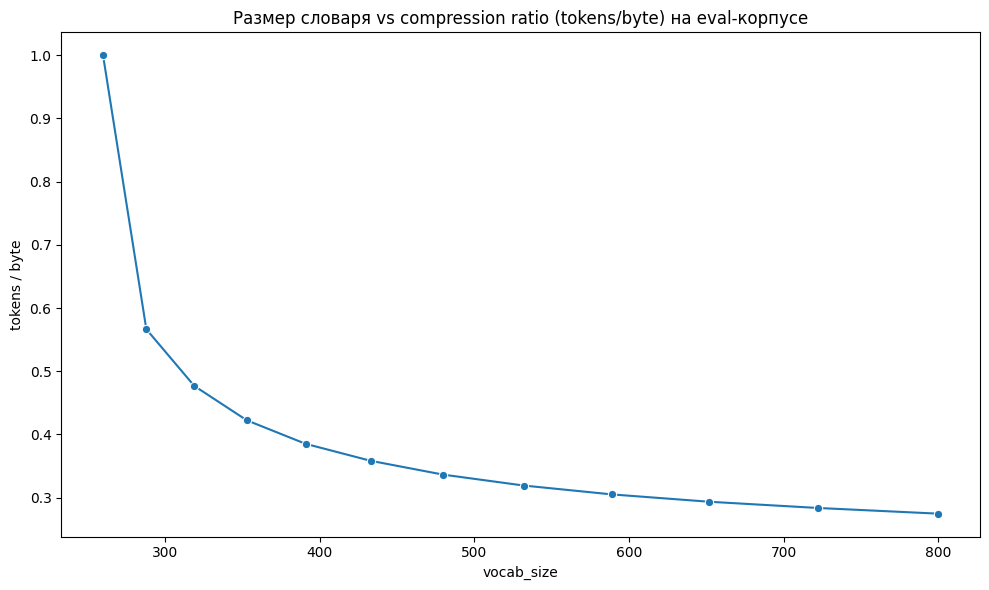

In [50]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_curve, x="vocab_size", y="tokens_per_byte", marker="o")
plt.title("Размер словаря vs compression ratio (tokens/byte) на eval-корпусе")
plt.xlabel("vocab_size")
plt.ylabel("tokens / byte")
plt.tight_layout()
plt.show()


Ожидаемое снижение коэффициента сжатия с увеличением размера словаря

### 1.1.4. Определите, какая часть токенов не использовалась ни разу при токенизации корпуса стихотворений Пушкина

In [59]:
def list_txt_files(root: Path) -> List[Path]:
    return sorted([p for p in root.rglob("*.txt") if p.is_file()])


root_dir = Path("dataverse_files/texts")
txt_files = list_txt_files(root_dir)

print(f"TXT files: {len(txt_files)}")

TXT files: 913


In [64]:
def compute_used_token_ids(tokenizer, files: List[Path]) -> Tuple[Set[int], int, int, int]:
    used: Set[int] = set()
    total_tokens = 0
    total_bytes = 0
    total_chars = 0

    for p in tqdm(files, desc="Tokenize Pushkin corpus"):
        text = Path.read_text(p, encoding="utf-8")
        if not text:
            continue
        ids = tokenizer.encode(text, add_special_tokens=False)
        used.update(ids)
        total_tokens += len(ids)
        total_bytes += len(text.encode("utf-8"))
        total_chars += len(text)

    return used, total_tokens, total_bytes, total_chars

In [65]:
used_ids, total_tokens, total_bytes, total_chars = compute_used_token_ids(tokenizer, txt_files)

vocab_ids = set(tokenizer.vocab.keys())
unused_ids = vocab_ids - used_ids

unused_share_all = len(unused_ids) / len(vocab_ids) if len(vocab_ids) else float("nan")

Tokenize Pushkin corpus: 100%|██████████| 913/913 [00:01<00:00, 526.31it/s]


In [66]:
special_ids = set()
for name in ("pad_token_id", "bos_token_id", "eos_token_id", "unk_token_id"):
    v = getattr(tokenizer, name, None)
    if v is not None:
        special_ids.add(int(v))

vocab_ids_wo_special = vocab_ids - special_ids
unused_ids_wo_special = vocab_ids_wo_special - used_ids
unused_share_wo_special = (
    len(unused_ids_wo_special) / len(vocab_ids_wo_special) if len(vocab_ids_wo_special) else float("nan")
)

In [67]:
print("\n=== Corpus summary ===")
print("files:", len(txt_files))
print("total chars:", total_chars)
print("total bytes:", total_bytes)
print("total tokens:", total_tokens)

print("\n=== Unused tokens in vocab ===")
print(f"vocab size (all): {len(vocab_ids)}")
print(f"used ids:         {len(used_ids)}")
print(f"unused ids:       {len(unused_ids)}")
print(f"unused share:     {unused_share_all:.4f} ({unused_share_all*100:.2f}%)")

print("\n=== Unused tokens (excluding special tokens) ===")
print(f"special ids:      {sorted(list(special_ids))}")
print(f"vocab w/o special:{len(vocab_ids_wo_special)}")
print(f"unused w/o spec:  {len(unused_ids_wo_special)}")
print(f"unused share:     {unused_share_wo_special:.4f} ({unused_share_wo_special*100:.2f}%)")


=== Corpus summary ===
files: 913
total chars: 719954
total bytes: 1272984
total tokens: 540347

=== Unused tokens in vocab ===
vocab size (all): 400
used ids:         268
unused ids:       132
unused share:     0.3300 (33.00%)

=== Unused tokens (excluding special tokens) ===
special ids:      [256, 257, 258, 259]
vocab w/o special:396
unused w/o spec:  128
unused share:     0.3232 (32.32%)


Мы получили сжатие чуть хуже, чем на анекдотах - так как применяли тексты из другой области. Примерно треть словаря (32%) не используется при токенизации

In [70]:
def pretty_token_bytes(b: bytes) -> str:
    """
    Делает читаемое представление байтового токена.
    """
    try:
        s = b.decode("utf-8")
        if any(ch.isprintable() and ch != "\x00" for ch in s):
            return s
    except Exception:
        pass
    return repr(b)

In [80]:
unused_sorted = sorted(list(unused_ids), key=lambda i: (len(tokenizer.vocab[i]), i))
print("\n=== Examples of unused tokens ===")
for tid in unused_sorted[-100:-80]:
    tb = tokenizer.vocab[tid]
    print(f"id={tid:5d} | token={pretty_token_bytes(tb)}")


=== Examples of unused tokens ===
id=   35 | token=#
id=   36 | token=$
id=   37 | token=%
id=   38 | token=&
id=   43 | token=+
id=   61 | token==
id=   64 | token=@
id=   89 | token=Y
id=   92 | token=\
id=   94 | token=^
id=   95 | token=_
id=   96 | token=`
id=  123 | token={
id=  124 | token=|
id=  125 | token=}
id=  126 | token=~
id=  127 | token=b'\x7f'
id=  129 | token=b'\x81'
id=  130 | token=b'\x82'
id=  131 | token=b'\x83'


## Задача 1.1. 3 балла

Обучите простую модель (можно RNN/n-gram/transformer) с вашим токенизатором.

Необходимо подготовить токенизатор таким образом, чтобы его можно было загрузить в GPT-2

In [ ]:
def bytes_to_unicode() -> Tuple[Dict[int, str], Dict[str, int]]:
    """
    Маппинг byte -> unicode char как в GPT-2 (OpenAI encoder.py).
    Позволяет представить любые байты в виде безопасной unicode-строки без пробелов/табов.
    """
    bs = list(range(33, 127)) + list(range(161, 173)) + list(range(174, 256))
    cs = bs[:]
    n = 0
    for b in range(256):
        if b not in bs:
            bs.append(b)
            cs.append(256 + n)
            n += 1
    byte2uni = {b: chr(c) for b, c in zip(bs, cs)}
    uni2byte = {chr(c): b for b, c in zip(bs, cs)}
    return byte2uni, uni2byte


def export_my_bpe_to_gpt2_files(bpe_tok, out_dir: str) -> Tuple[str, str]:
    """
    Экспорт BpeTokenizer -> (vocab.json, merges.txt) в формате GPT-2.

    """
    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)

    byte2uni, _ = bytes_to_unicode()

    special_bytes = {
        bpe_tok.pad_token,
        bpe_tok.bos_token,
        bpe_tok.eos_token,
        bpe_tok.unk_token,
    }

    # id -> token_string
    id2tok: Dict[int, str] = {}
    for tid, b in bpe_tok.vocab.items():
        if b in special_bytes:
            # спецтокены пишем как нормальные строки
            id2tok[int(tid)] = b.decode("utf-8")
        else:
            # обычные токены: bytes -> safe unicode string
            id2tok[int(tid)] = "".join(byte2uni[x] for x in b)

    # Проверка на уникальность токенов
    if len(set(id2tok.values())) != len(id2tok):
        rev: Dict[str, List[int]] = {}
        for i, s in id2tok.items():
            rev.setdefault(s, []).append(i)
        collisions = {s: ids for s, ids in rev.items() if len(ids) > 1}
        raise RuntimeError(f"Коллизии токенов при экспорте (пример): {list(collisions.items())[:5]}")

    vocab_json = {tok: tid for tid, tok in id2tok.items()}

    vocab_path = out / "vocab.json"
    merges_path = out / "merges.txt"

    with open(vocab_path, "w", encoding="utf-8") as f:
        json.dump(vocab_json, f, ensure_ascii=False)

    with open(merges_path, "w", encoding="utf-8") as f:
        f.write("#version: 0.2\n")
        for a, b in bpe_tok.merge_rules:
            f.write(f"{id2tok[int(a)]} {id2tok[int(b)]}\n")

    return str(vocab_path), str(merges_path)

In [ ]:
tok_dir = "hf_tokenizer_from_my_bpe"
vocab_file, merges_file = export_my_bpe_to_gpt2_files(tokenizer, tok_dir)
print("exported to:", tok_dir)

exported to: hf_tokenizer_from_my_bpe


In [98]:
hf_tok = GPT2TokenizerFast(
    vocab_file=vocab_file,
    merges_file=merges_file,
    unk_token="<unk>",
    bos_token="<bos>",
    eos_token="<eos>",
    pad_token="<pad>",
    add_prefix_space=True,  
)

print("hf_tok vocab size:", len(hf_tok))

hf_tok vocab size: 400


In [101]:
train_ds = Dataset.from_dict({"text": anecdotes_train})
eval_ds  = Dataset.from_dict({"text": anecdotes_test})

def tokenize_batch(batch):
    # Ключевой момент: НЕ возвращаем attention_mask
    out = hf_tok(
        batch["text"],
        add_special_tokens=False,
        return_attention_mask=False,
    )
    eos = hf_tok.eos_token_id
    out["input_ids"] = [ids + [eos] for ids in out["input_ids"]]
    return out

train_tok = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
eval_tok  = eval_ds.map(tokenize_batch,  batched=True, remove_columns=["text"])

train_tok = train_tok.remove_columns([c for c in train_tok.column_names if c != "input_ids"])
eval_tok  = eval_tok.remove_columns([c for c in eval_tok.column_names  if c != "input_ids"])

block_size = 1024

Map: 100%|██████████| 8822/8822 [00:00<00:00, 29677.34 examples/s]


In [102]:
def group_texts(examples):
    concatenated = []
    for ids in examples["input_ids"]:
        concatenated.extend(ids)

    total_len = (len(concatenated) // block_size) * block_size
    concatenated = concatenated[:total_len]

    input_ids = [concatenated[i:i + block_size] for i in range(0, total_len, block_size)]
    return {"input_ids": input_ids, "labels": [x[:] for x in input_ids]}

train_lm = train_tok.map(group_texts, batched=True)
eval_lm  = eval_tok.map(group_texts,  batched=True)

Map: 100%|██████████| 8822/8822 [00:00<00:00, 21539.29 examples/s]


In [103]:
print("train blocks:", len(train_lm), "eval blocks:", len(eval_lm))
print("columns:", train_lm.column_names)

train blocks: 4715 eval blocks: 1170
columns: ['input_ids', 'labels']


In [115]:
pad_id = int(hf_tok.pad_token_id)
bos_id = int(hf_tok.bos_token_id)
eos_id = int(hf_tok.eos_token_id)
vocab_size = len(hf_tok)

In [129]:
class RnnLMDataset(Dataset):
    def __init__(self, texts: List[str], tokenizer, max_len: int = 128):
        self.samples: List[List[int]] = []
        for t in texts:
            ids = tokenizer.encode(t, add_special_tokens=False)
            ids = [bos_id] + ids + [eos_id]
            if len(ids) > max_len:
                ids = ids[: max_len - 1] + [eos_id]
            if len(ids) < 2:
                ids = [bos_id, eos_id]
            self.samples.append(ids)

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: Union[int, List[int]]):
        # ВАЖНО: DataLoader иногда передаёт список индексов -> вернём список примеров
        if isinstance(idx, list):
            return [self.samples[i] for i in idx]
        return self.samples[idx]


def collate_pad(batch):
    """
    batch может быть:
      - List[List[int]] (обычный режим)
      - или List[ List[List[int]] ] если dataset вернул батч списком (см. __getitem__)
    Приведём к плоскому списку последовательностей.
    """
    if len(batch) > 0 and isinstance(batch[0], list) and len(batch[0]) > 0 and isinstance(batch[0][0], list):
        # batch = [ [seq, seq, ...], [seq, ...], ... ] -> расплющим
        flat = []
        for part in batch:
            flat.extend(part)
        batch = flat

    max_len = max(len(x) for x in batch)
    input_ids = torch.full((len(batch), max_len), pad_id, dtype=torch.long)
    for i, ids in enumerate(batch):
        input_ids[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)
    return {"input_ids": input_ids}

In [130]:
class SimpleRNNLM(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 128, hidden_dim: int = 256):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            nonlinearity="tanh",
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        x = self.emb(input_ids)     # (B,T,E)
        h, _ = self.rnn(x)          # (B,T,H)
        return self.fc(h)           # (B,T,V)


def ce_loss_ignore_pad(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return nn.functional.cross_entropy(
        logits.reshape(-1, logits.size(-1)),
        targets.reshape(-1),
        ignore_index=pad_id,
    )


@torch.no_grad()
def eval_ppl(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for batch in loader:
        ids = batch["input_ids"].to(device)
        x = ids[:, :-1]
        y = ids[:, 1:]

        logits = model(x)
        loss = ce_loss_ignore_pad(logits, y)

        tokens = (y != pad_id).sum().item()
        total_loss += loss.item() * tokens
        total_tokens += tokens

    avg_loss = total_loss / max(1, total_tokens)
    ppl = float(math.exp(avg_loss)) if avg_loss < 50 else float("inf")
    return ppl


def train_rnn(model, train_loader, test_loader, device, epochs=2, lr=3e-4, grad_clip=1.0):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}")

        for batch in pbar:
            ids = batch["input_ids"].to(device)
            x = ids[:, :-1]
            y = ids[:, 1:]

            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = ce_loss_ignore_pad(logits, y)
            loss.backward()

            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            opt.step()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        ppl = eval_ppl(model, test_loader, device)
        print(f"[epoch {ep}] test perplexity = {ppl:.2f}")

    return model

In [131]:
max_len = 128
batch_size = 64

train_ds = RnnLMDataset(anecdotes_train, hf_tok, max_len=max_len)
test_ds  = RnnLMDataset(anecdotes_test,  hf_tok, max_len=max_len)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_pad, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, collate_fn=collate_pad, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

model = SimpleRNNLM(vocab_size=vocab_size, emb_dim=128, hidden_dim=256)
model = train_rnn(model, train_loader, test_loader, device, epochs=2, lr=3e-4, grad_clip=1.0)

device: cuda


Epoch 1/2: 100%|██████████| 552/552 [00:02<00:00, 218.28it/s, loss=3.5027]


[epoch 1] test perplexity = 28.24


Epoch 2/2: 100%|██████████| 552/552 [00:01<00:00, 291.10it/s, loss=3.1254]


[epoch 2] test perplexity = 21.86


In [121]:
@torch.no_grad()
def sample_top_k(logits_1d: torch.Tensor, top_k: int = 50, temperature: float = 1.0) -> int:
    logits_1d = logits_1d / max(1e-6, float(temperature))
    k = min(int(top_k), logits_1d.numel())
    vals, idx = torch.topk(logits_1d, k=k)
    probs = torch.softmax(vals, dim=-1)
    choice = torch.multinomial(probs, num_samples=1).item()
    return int(idx[choice].item())


@torch.no_grad()
def generate_rnn(model: nn.Module, tokenizer, prompt: str, max_new_tokens: int = 80, top_k: int = 50, temperature: float = 0.9) -> str:
    model.eval()
    device = next(model.parameters()).device

    ids = tokenizer.encode(prompt, add_special_tokens=False)
    ids = [bos_id] + ids
    x = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):
        logits = model(x)               # (1, T, V)
        next_logits = logits[0, -1, :]  # (V,)
        next_id = sample_top_k(next_logits, top_k=top_k, temperature=temperature)
        x = torch.cat([x, torch.tensor([[next_id]], device=device)], dim=1)
        if next_id == eos_id:
            break

    out_ids = x[0].tolist()
    if out_ids and out_ids[0] == bos_id:
        out_ids = out_ids[1:]
    return tokenizer.decode(out_ids, skip_special_tokens=True)

In [132]:
print(generate_rnn(model, hf_tok, "— Поручик Ржевский,", max_new_tokens=80, top_k=50, temperature=0.9))

 — Поручик Ржевский, и говорит: — Когда к все прогодля проходит оргавленный лябушка сейчас его на очнуль такой попросил своим сегаждывает слечина �


В целом, до прямой речи поручика текст был даже логичным ...

## Задача 1.2. 2 балла

Замените токенизатор GPT-2 на ваш (обученный на текстах, содержащих русский язык) и дообучите уже предобученный GPT-2 124M на нем.

In [104]:
model = GPT2LMHeadModel.from_pretrained("gpt2")  # GPT-2 124M
model.resize_token_embeddings(len(hf_tok))


c:\Users\user\PycharmProjects\trader\venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For 

Embedding(400, 768)

In [106]:
model.config.pad_token_id = hf_tok.pad_token_id
model.config.bos_token_id = hf_tok.bos_token_id
model.config.eos_token_id = hf_tok.eos_token_id

init_std = model.config.initializer_range
model.transformer.wte.weight.data.normal_(mean=0.0, std=init_std)
model.tie_weights()

print("model vocab:", model.get_input_embeddings().weight.shape[0])

model vocab: 400


In [108]:
use_fp16 = torch.cuda.is_available()

out_dir = "gpt2_124m_finetuned_my_bpe"

args = TrainingArguments(
    output_dir=out_dir,
    overwrite_output_dir=True,

    num_train_epochs=1.0,
    learning_rate=5e-5,
    warmup_steps=200,
    weight_decay=0.01,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,

    eval_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,

    fp16=bool(use_fp16),
    report_to="none",
    seed=42,
)


In [109]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_lm,
    eval_dataset=eval_lm,
    data_collator=default_data_collator,
    tokenizer=hf_tok,
)

C:\Users\user\AppData\Local\Temp\ipykernel_19788\3861733687.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [110]:
trainer.train()

trainer.save_model(out_dir)
hf_tok.save_pretrained(out_dir)
print("saved to:", out_dir)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 258, 'bos_token_id': 257, 'pad_token_id': 256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


saved to: gpt2_124m_finetuned_my_bpe


In [114]:
prompt = "— Поручик Ржевский,"
inputs = hf_tok(prompt, return_tensors="pt")

model.cuda()
inputs = {k: v.cuda() for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    out = model.generate(
        **inputs,
        max_new_tokens=80,
        do_sample=True,
        top_p=0.95,
        temperature=0.9,
        pad_token_id=hf_tok.pad_token_id,
        eos_token_id=hf_tok.eos_token_id,
    )

print(hf_tok.decode(out[0], skip_special_tokens=True))

 — Поручик Ржевский,уон сл -?алчч т�е�чньстол д�ушеть,омш д к �рк м дыьдшуач, иичш - с н нен - вын н петы,? сс,!сачюо�р иелк, в


:)